In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

from TE import transfer_entropy

# Test: Transfer Entropy between timeseries
 
Here we test TE between an auto-correlated time series \( Y \) and a derived time series \( X \), assessing how different weight contributions from \( Y \) affect the value of the transfer entropy (TE).
The TE(Y->X) is computed using `transfer_entropy(X, Y, delay)` to assess how relevant the information in Y at a given delay is in predicting future values of X.

- **Plot 1** :As the weight W_Y increases, we see lower values of Transfer Entropy, indicating a higher capability of predicting future values of X.

- **Plot 2** :Subsequently, we show that comparing different `delay` values at which TE is evaluated also allows to find the T_LAG used to generate X as a rolled version of Y

## Generating Time Series:

- Y is generated as an auto-correlated time series using an AR(1) process, meaning each value depends on the previous one with some added noise and an coefficient.  
- K is generated as an independent noise series with no auto-correlation.

- X is then computed as alagged and noisy linear combination of Y and K:
    - $ X[t] = W_Y \cdot Y[t-T_{LAG}] + (1- W_Y) \cdot K[t-T_{LAG}] $
    - The $T_{LAG}$ determines the lag with which X is generated as a shifted version of Y and K
    - The weight parameter W_Y determines how much Y contributes to X. The lag is currently set to 3 time steps. 

In [2]:
def stochastic_timeseries(W_Y, T_LAG = 3, length=1000, noise_level=0.01, ar_coeff=0.8):
    """
    generate time series where Y is an auto-correlated series, K is independent and non correlated,
    and X is a lagged and noisy combination of Y and K.
    
    params:
    - W_Y: Weight for Y in determining X.
    - length: length of the time series.
    - noise_level: std of the gaussian noise.
    - ar_coeff: coefficient for AR(1) process of Y.
    
    returns:
    - X, Y, K: generated time series.
    """
    np.random.seed(42)
    
    # Generate auto-correlated Y
    Y = np.zeros(length)
    Y[0] = np.random.randn()
    for t in range(1, length):
        Y[t] = ar_coeff * Y[t-1] + np.random.randn()
    
    # Generate independent noise series K
    K = np.random.randn(length)
    
    # Compute X as a lagged and noisy combination of Y and K
    W_K = 1. - W_Y
    X = W_Y * np.roll(Y, shift=3) + W_K * np.roll(K, shift=T_LAG) + noise_level * np.random.randn(length)
    
    return X, Y, K

## Testing Transfer Entropy:  
   - We evaluate Transfer Entropy (TE) from Y to X at a delay of 3 to see how well Y predicts X. TE quantifies how much knowing Y at a given delay helps predict future values of X.  

## [1] Plot 1:  
   - The following plot shows six different cases where W_Y increases from 0.1 to 1.  
   - Higher W_Y (stronger influence of Y on X) corresponds to higher opacity in the plot.  
   - As W_Y increases, TE(Y → X) decreases, meaning that Y becomes a stronger predictor of X, which is expected because X is constructed from a weighted delayed version of Y.   



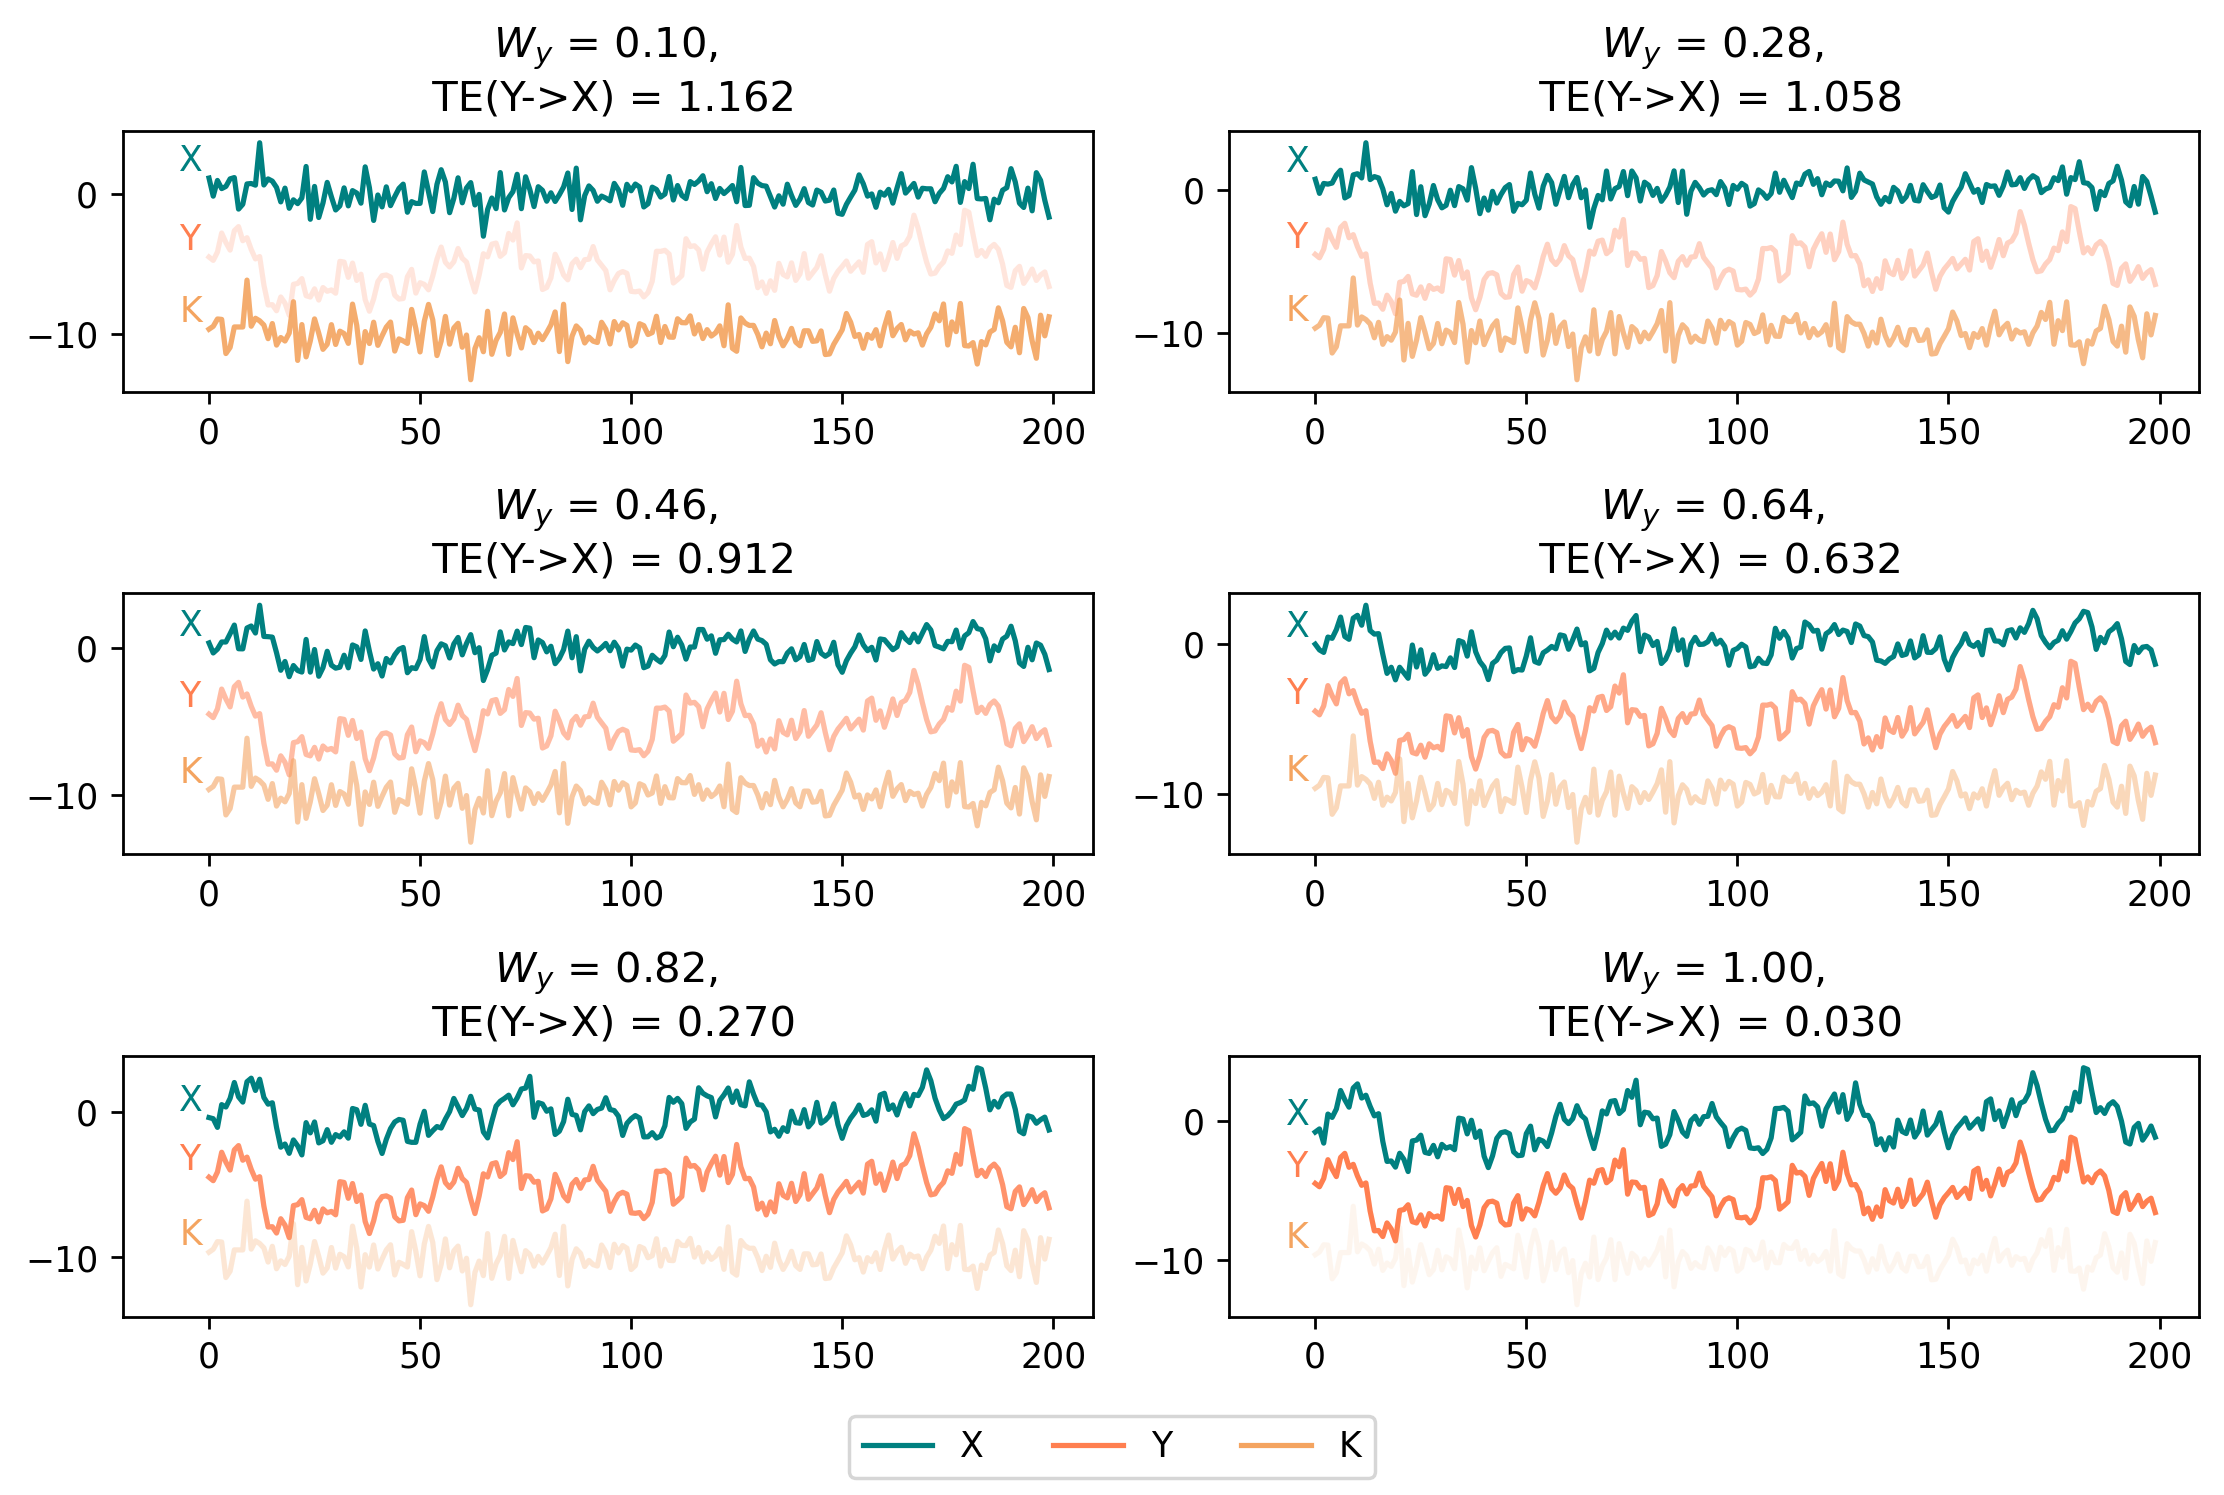

In [3]:
def plot_timeseries_with_TE():
    W_Y_values = np.linspace(0.1, 1, 6)
    length = 200
    
    fig, axes = plt.subplots(3, 2, figsize=(9, 6), dpi=250)
    axes = axes.flatten()
    
    for i, W_Y in enumerate(W_Y_values):
        
        X, Y, K = stochastic_timeseries(W_Y, length=length)
        TE_YX = transfer_entropy(X, Y, delay=3)
        
        axes[i].plot(X, label='X',color = 'teal', alpha=1.0)
        axes[i].plot(Y - 5, color = 'coral', alpha=W_Y)
        axes[i].plot(Y - 5, label='Y', color = 'coral',  alpha=0.1)
        axes[i].plot(K - 10, color = 'sandybrown', alpha=1-W_Y)
        axes[i].plot(K - 10, color = 'sandybrown', label='K',  alpha=0.1)
        axes[i].plot(np.arange(-10,0), np.ones(10), color='white', alpha=0.0)
        
        # Add labels at the beginning of each time series
        axes[i].text(-7, X[0], f'X', color='teal', verticalalignment='bottom')
        axes[i].text(-7, Y[0] - 5, f'Y', color='coral', verticalalignment='bottom')
        axes[i].text(-7, K[0] - 10, f'K', color='sandybrown', verticalalignment='bottom')
        
        axes[i].set_title(fr'$W_y$' + f' = {W_Y:.2f}, \n TE(Y->X) = {TE_YX:.3f}')

    handles = [plt.Line2D([0], [0], color='teal', label='X'),
               plt.Line2D([0], [0], color='coral', label='Y'),
               plt.Line2D([0], [0], color='sandybrown', label='K')]
    fig.legend(handles=handles, loc='lower center', ncol=3)
    
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()

# plot
plot_timeseries_with_TE()



## [2] Plot 2 (Transfer Entropy vs delay):  
- Transfer entropy is the lowest when the `delay` used to evaluate the TE between X and Y coincides to the T_LAG used to generate X from Y, as expected.
- Since X is a rolled version of Y with a delay of 3, the choice of delay in evaluating TE is crucial. A mismatched delay would lead to misleading TE values.  


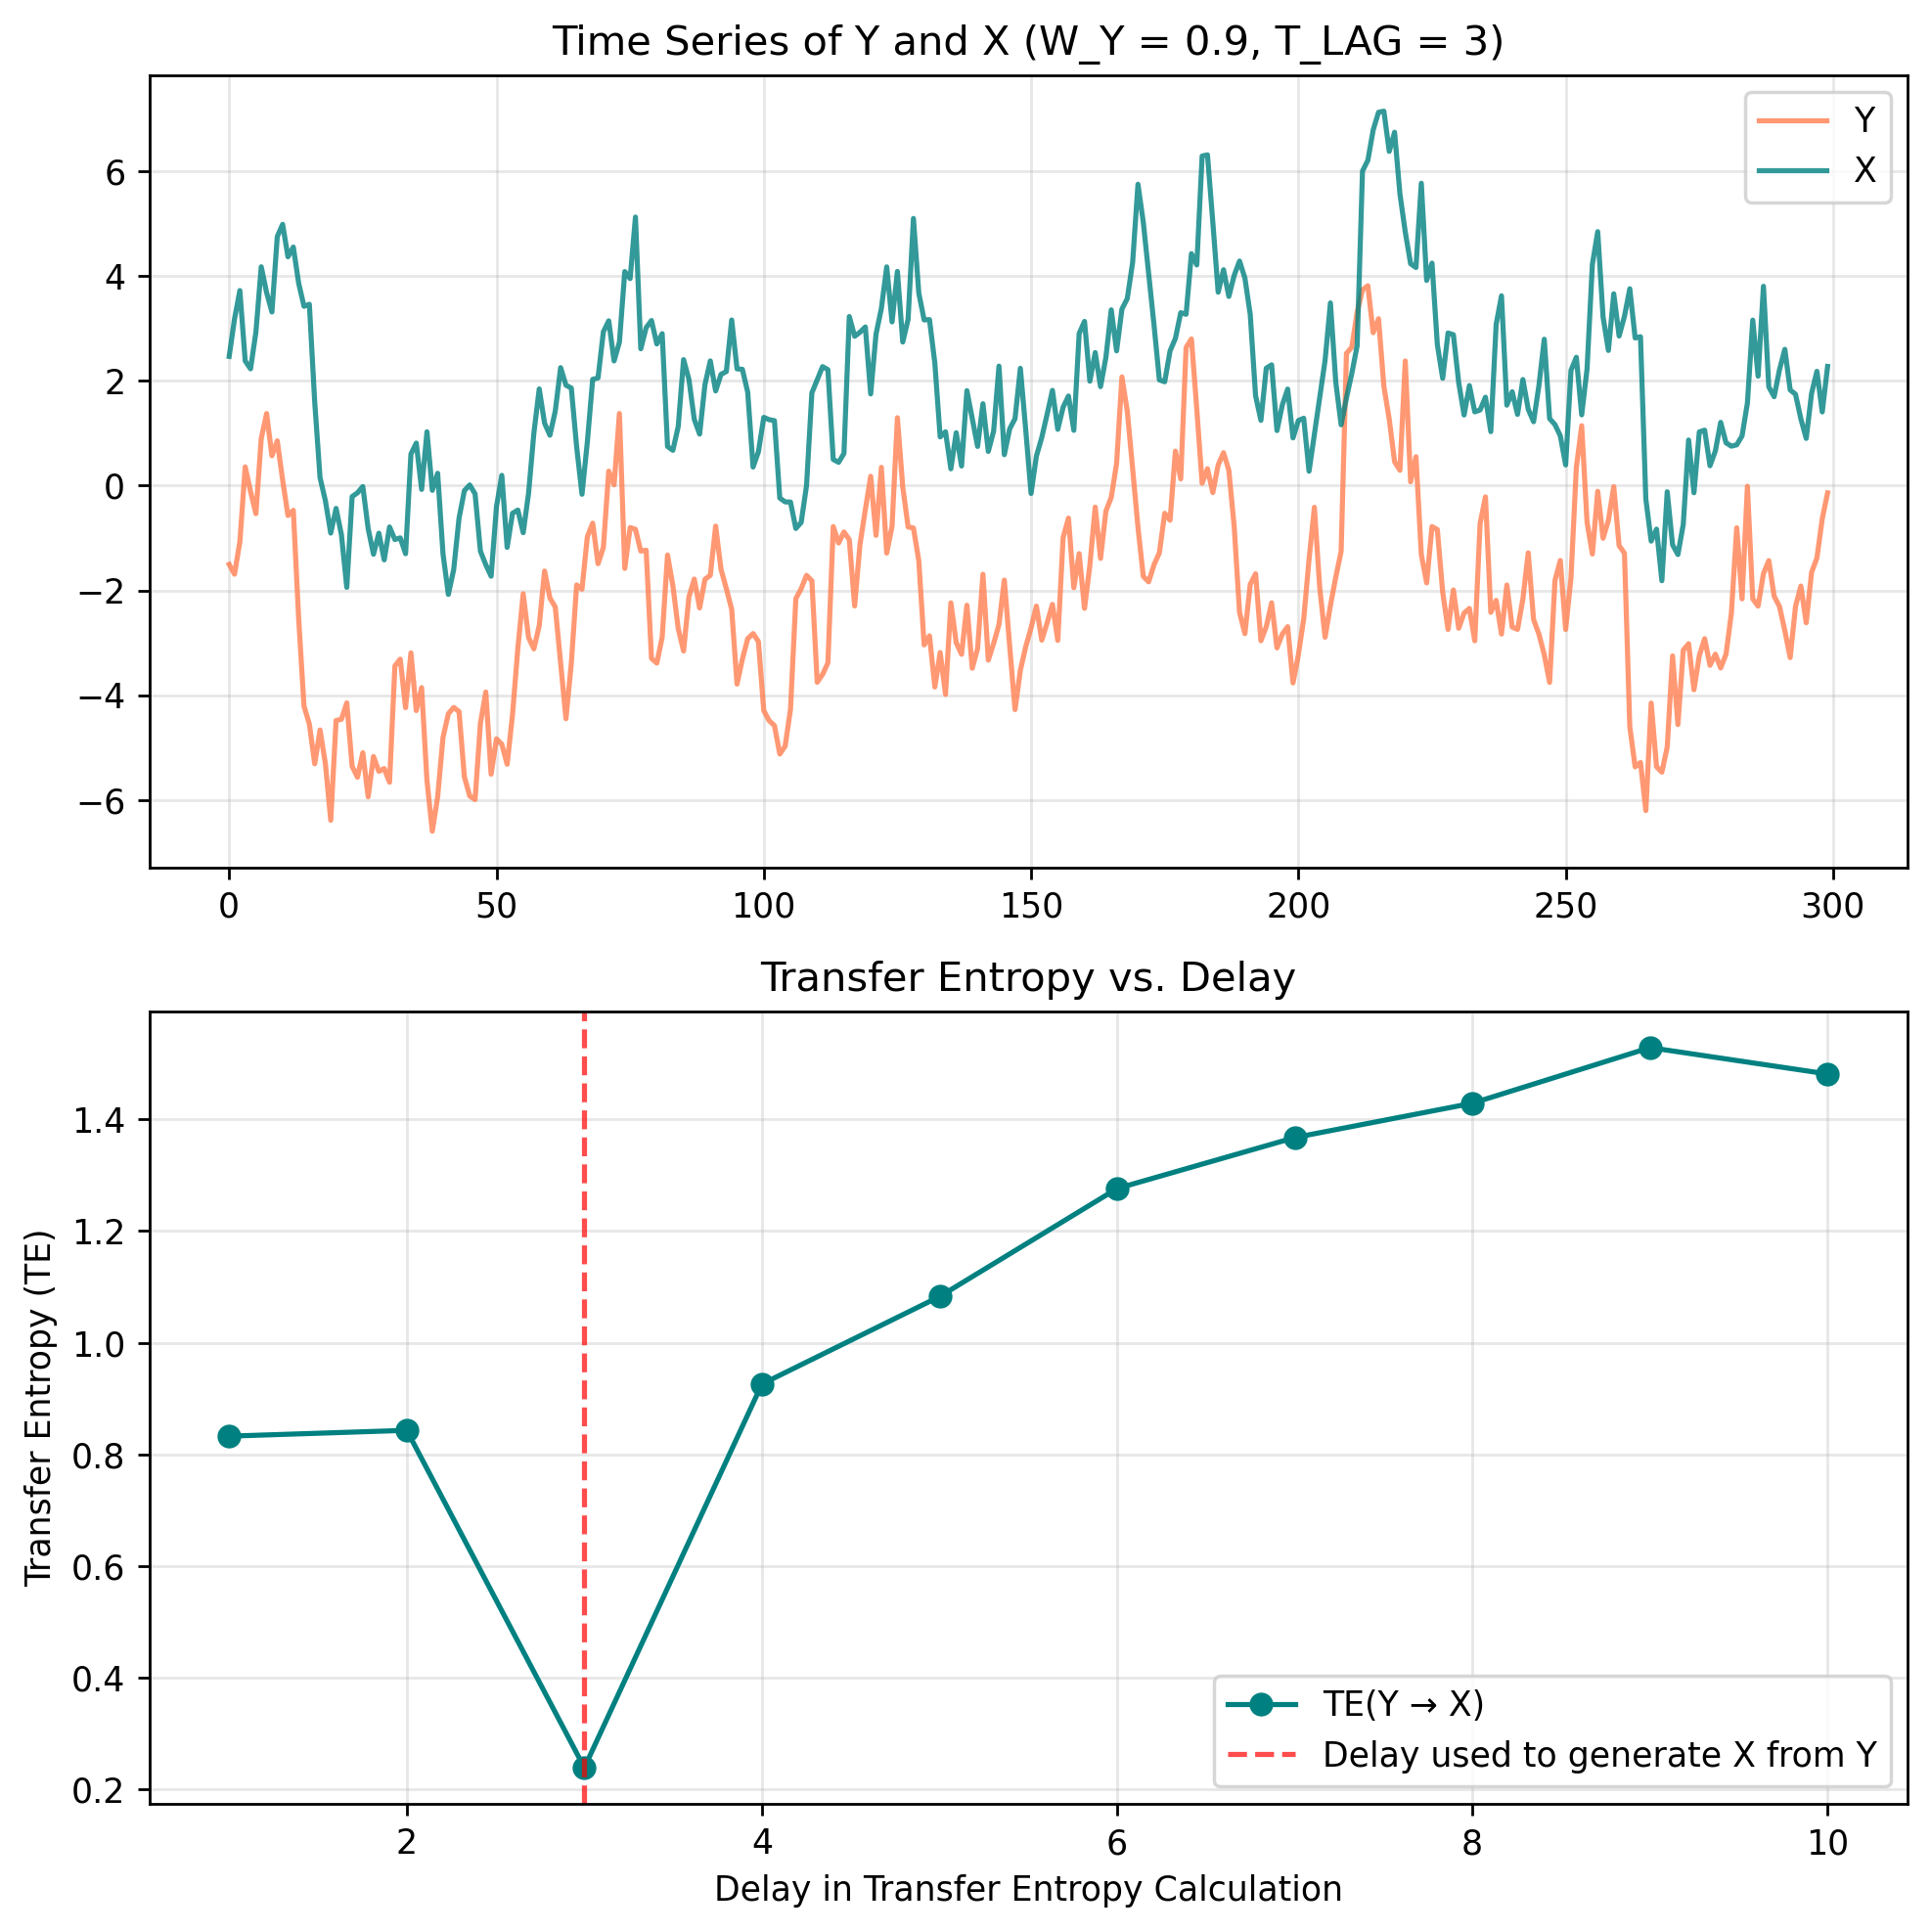

In [4]:

def plot_TE_vs_delay(W_Y=0.9, max_delay=10):
    X, Y, K = stochastic_timeseries(W_Y, length=300, noise_level=0.01, ar_coeff=0.9)
    
    delays = np.arange(1, max_delay + 1)
    TE_values = [transfer_entropy(X, Y, delay=d) for d in delays]  # Compute TE for each delay


    fig, axes = plt.subplots(2, 1, figsize=(8, 8), dpi=250, gridspec_kw={'height_ratios': [1, 1]})
    

    axes[0].plot(Y - 2, label='Y', color='coral', alpha=0.8)  # shift Y for better visualization
    axes[0].plot(X + 2, label='X', color='teal', alpha=0.8)  # shift X for better visualization
    axes[0].set_title(f'Time Series of Y and X (W_Y = {W_Y}, T_LAG = 3)')
    axes[0].legend()
    axes[0].grid(alpha=0.3)


    axes[1].plot(delays, TE_values, marker='o', linestyle='-', color='teal', label='TE(Y → X)')
    axes[1].axvline(3, color='red', linestyle='--', alpha=0.7, label='Delay used to generate X from Y')
    
    axes[1].set_xlabel('Delay in Transfer Entropy Calculation')
    axes[1].set_ylabel('Transfer Entropy (TE)')
    axes[1].set_title(f'Transfer Entropy vs. Delay')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

# plot
plot_TE_vs_delay()


In [ ]:
'''

# additional systems (to be implemented in the future)

def lorenz_system(t, state, sigma=10, beta=8/3, rho=28):
    x, y, z = state
    dx_dt = sigma * (y - x)
    dy_dt = x * (rho - z) - y
    dz_dt = x * y - beta * z
    return [dx_dt, dy_dt, dz_dt]


def dynamical_system_timeseries(type="lorenz", length=1000, dt=0.01, noise_level=0.1):
    np.random.seed(42)
    t_span = [0, length * dt]
    t_eval = np.linspace(*t_span, length)
    
    if type == "lorenz":
        sol = solve_ivp(lorenz_system, t_span, [1.0, 1.0, 1.0], t_eval=t_eval)
        X, Y = sol.y[0], sol.y[1]

    elif type == "coupled":
        def independent_system(t, state):
            x, y, z, w = state
            dx_dt = 10 * (y - x) + 0.3* w # X influenced by W but W evolves independently
            dy_dt = x * (28 - z) - y
            dz_dt = x * y - (8/3) * z
            dw_dt = -0.1 * w # W evolves independently
            #dw_dt = -0.1 * w + x # here coupling is stronger and we see lower entropy
            return [dx_dt, dy_dt, dz_dt, dw_dt]
        
        sol = solve_ivp(independent_system, t_span, [1.0, 1.0, 1.0, 1.0], t_eval=t_eval)
        X, Y = sol.y[0], sol.y[3]  # W evolves independently but affects X

    else:
        raise ValueError("Invalid type. Choose 'lorenz', 'coupled'.")
    
    X += noise_level * np.random.randn(length)
    Y += noise_level * np.random.randn(length)
    
    return X, Y

'''

'\n\n# additional systems (to be implemented in the future)\n\ndef lorenz_system(t, state, sigma=10, beta=8/3, rho=28):\n    x, y, z = state\n    dx_dt = sigma * (y - x)\n    dy_dt = x * (rho - z) - y\n    dz_dt = x * y - beta * z\n    return [dx_dt, dy_dt, dz_dt]\n\n\ndef dynamical_system_timeseries(type="lorenz", length=1000, dt=0.01, noise_level=0.1):\n    np.random.seed(42)\n    t_span = [0, length * dt]\n    t_eval = np.linspace(*t_span, length)\n    \n    if type == "lorenz":\n        sol = solve_ivp(lorenz_system, t_span, [1.0, 1.0, 1.0], t_eval=t_eval)\n        X, Y = sol.y[0], sol.y[1]\n\n    elif type == "coupled":\n        def independent_system(t, state):\n            x, y, z, w = state\n            dx_dt = 10 * (y - x) + 0.3* w # X influenced by W but W evolves independently\n            dy_dt = x * (28 - z) - y\n            dz_dt = x * y - (8/3) * z\n            dw_dt = -0.1 * w # W evolves independently\n            #dw_dt = -0.1 * w + x # here coupling is stronger and w